## Linear regression with time series: Tunnel traffic

In [2]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10, )

plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False,)
%config InlineBackend.figure_format = 'retina'

# Load Tunnel Traffic dataset
data_dir = Path("data/")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head()


,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


Create the time-step feature

In [3]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


Create the Linear regression model using the time-step feature.

In [5]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

print(f"here are the regression parameters: coef={model.coef_}, intercept={model.intercept_}")


here are the regression parameters: coef=[22.49744953], intercept=98176.20634409295


Here the model

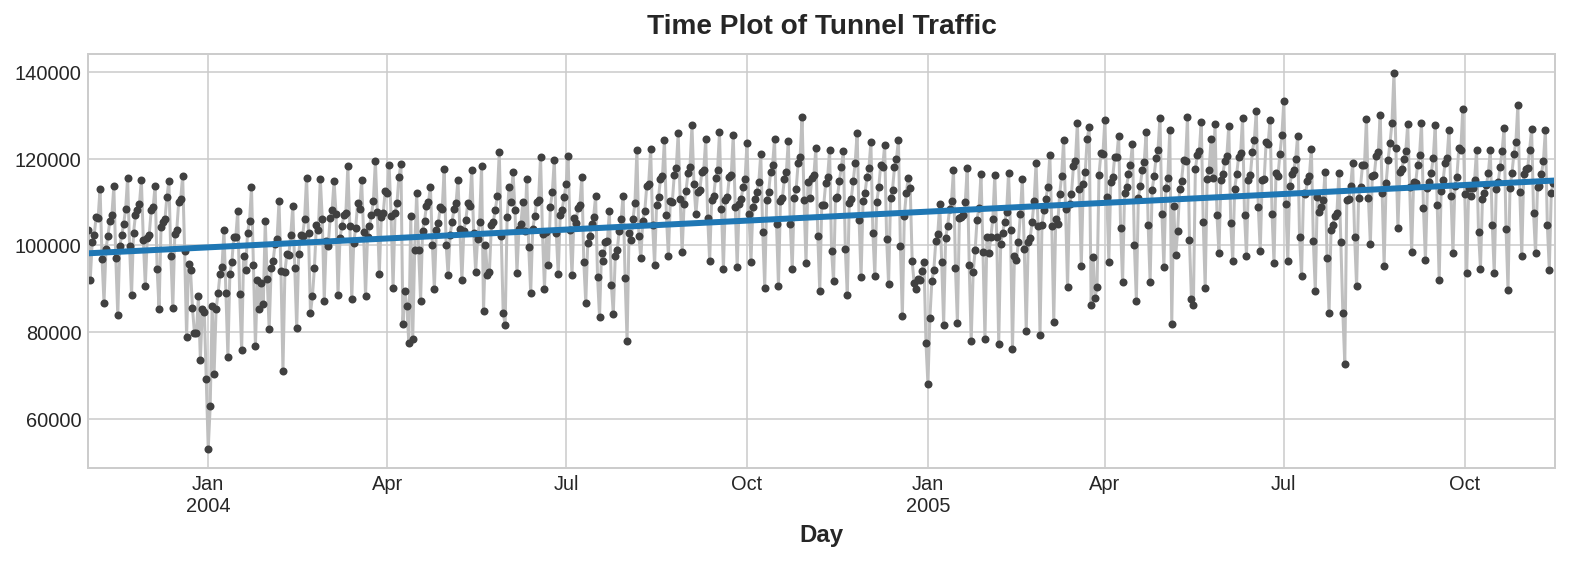

In [6]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

Now, let's create a lag feature

In [7]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [12]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]

print(X.head())

X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

print(f"here are the regression parameters: coef={model.coef_}, intercept={model.intercept_}")


               Lag_1
Day                 
2003-11-01       NaN
2003-11-02  103536.0
2003-11-03   92051.0
2003-11-04  100795.0
2003-11-05  102352.0
here are the regression parameters: coef=[0.53296606], intercept=49780.62486906959


The lag plot shows us how well we were able to fit the relationship between the number of vehicles one day and the number the previous day.

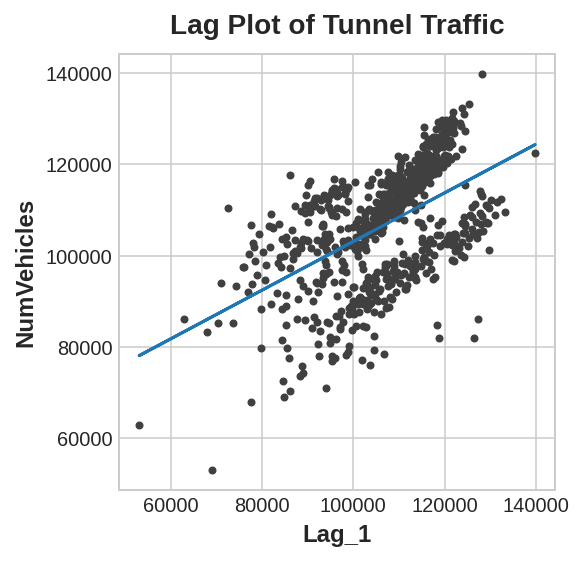

In [10]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

What does this prediction from a lag feature mean about how well we can predict the series across time? The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past.

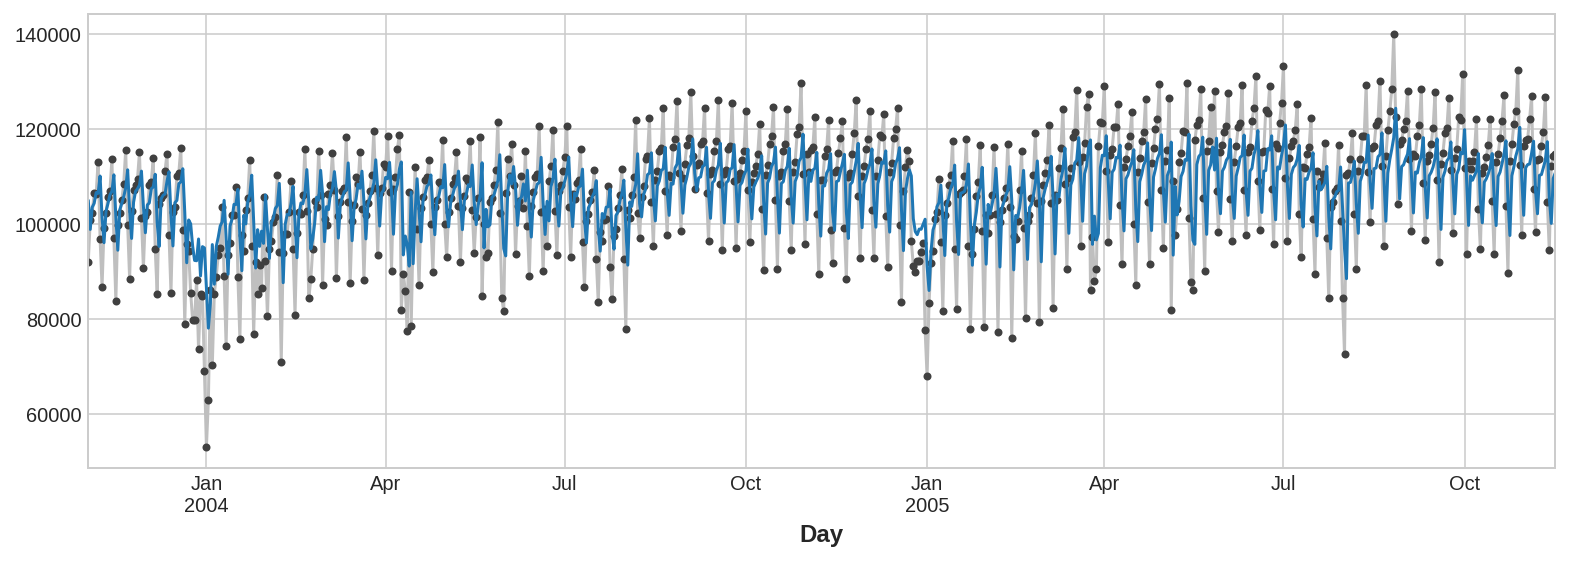

In [11]:
ax = y.plot(**plot_params)
ax = y_pred.plot()